In [1]:
# This notebook is used to test the draculab's topology class 
# By Sergio Verduzco Flores                August 2017

# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import time

/home/z/projects/draculab


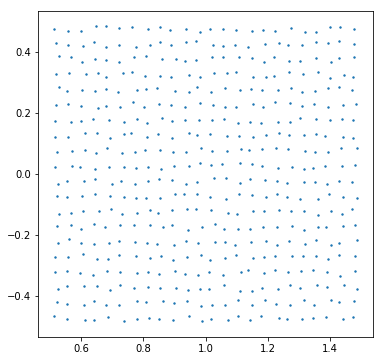

In [2]:
""" This cell is meant to test the create_group method with the 'sheet' shape and 'grid' arrangement """
topo = topology()

# Create network
net_params = {'min_delay' : 0.2, 'min_buff_size' : 4 } # parameter dictionary for the network
net = network(net_params)

# Create group of units
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
geom = { 'shape':'sheet', 'extent':[1.,1.], 'center':[1.,0.], 'arrangement':'grid', 
         'rows':20, 'columns':24, 'jitter' : 0.01 }
ids = topo.create_group(net, geom, unit_pars)
xvals = [ u.coordinates[0] for u in net.units ]
yvals = [ u.coordinates[1] for u in net.units ]

figg = plt.figure(figsize=(6,6))
plt.scatter(xvals, yvals, s=2.)
plt.show()

In [3]:
""" This cell tests the topo_connect method continuing with the network in the previous cell. """

# create the spec dictionaries
conn_spec = {'connection_type' : 'divergent',
             #'number_of_connections' : 20,
             #'mask' : {'rectangular':{'lower_left':[-1.,-4.], 'upper_right':[3.,-1.5]}}, 
             'mask' : {"annular" : {"inner_radius": .2, 'outer_radius':.5}},
             #'mask' : {'circular' : {'radius' : 3}},
             'kernel' : 1., 
             #'kernel' : {'gaussian':{'p_center':.2, 'sigma':3.}},
             #'kernel' : {'linear' : {'c' : 1., 'a' : .3}},
             'delays' : {'linear' : {'c':0.1, 'a':0.1}},
             'weights' : {'linear' : {'c':5., 'a':1.}},
             'edge_wrap' : True,
             'boundary' : {'center' : geom['center'], 'extent' : geom['extent']},
            }
syn_spec = {'type' : synapse_types.static, 'init_w' : 0.2 }

# connect
topo.topo_connect(net, ids, ids, conn_spec, syn_spec)

<IPython.core.display.Javascript object>


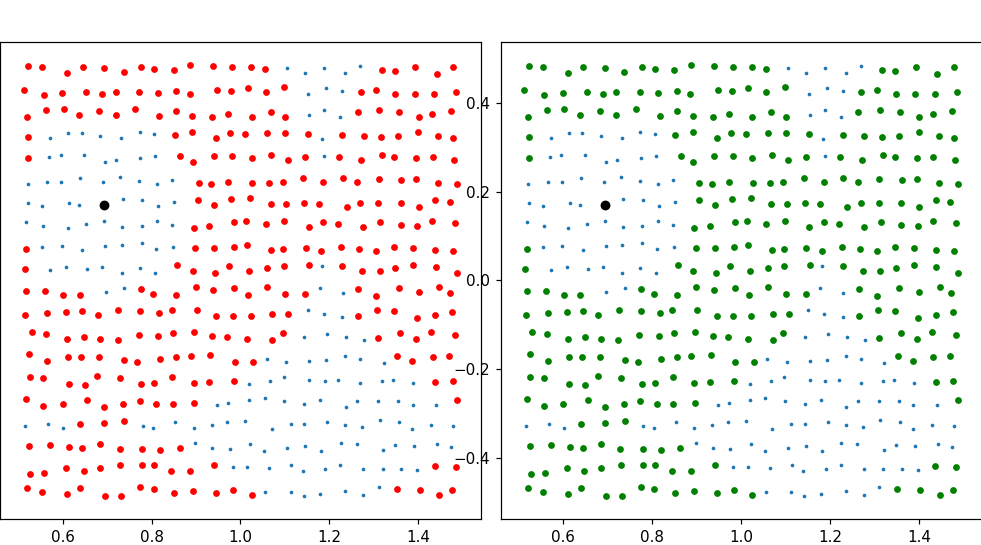

In [4]:
# visualizing the connections 
%matplotlib notebook
# The 'notebook' backend is compatible with FuncAnimation

# flattening net.syns
all_syns = []
for syn_list in net.syns:
    all_syns += syn_list
    
# getting a list with the coordinates of all units
all_coords = [u.coordinates for u in net.units]

fig = plt.figure(figsize=(9,5))
ax1 = fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
ax2 = fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
ax1.plot(xvals, yvals, 'c.')
ax2.plot(xvals, yvals, 'c.')

# At each frame we'll visualize the connections arising from a single unit
def update(frame): 
    u = (frame*1)%480 # unit we'll visualize
    
    # getting targets of projections from the unit 'u'
    targets = [syn.postID for syn in all_syns if syn.preID == u]
    tar_coords = [ all_coords[t] for t in targets ]
    #coords = [ unit.coordinates for unit in [net.units[idx] for idx in targets] ]
    tar_xcoords = [c[0] for c in tar_coords]
    tar_ycoords = [c[1] for c in tar_coords]
    ax1.clear()
    #ax.plot(xvals, yvals, 'c.')
    #ax.plot(xcoords, ycoords, 'ro', net.units[u].coordinates[0], net.units[u].coordinates[1], 'ko')
    ax1.scatter(xvals, yvals, s=2)
    ax1.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax1.scatter(tar_xcoords, tar_ycoords, s=12, c="red")
    
    
    # getting units that project to unit 'u'
    sources = [ syn.preID for syn in net.syns[u] ]
    sour_coords = [ all_coords[s] for s in sources ]
    sour_xcoords = [ c[0] for c in sour_coords ]
    sour_ycoords = [ c[1] for c in sour_coords ]
    ax2.clear()
    ax2.scatter(xvals, yvals, s=2)
    ax2.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax2.scatter(sour_xcoords, sour_ycoords, s=12, c="green")
    
    return ax1,ax2,

animation = FuncAnimation(fig, update, interval=15, blit=True)
plt.show()

In [3]:
class plotter():
    """ A class to contain the conn_anim method from ei_net. """
    
    def __init__(self, net):
        self.net = net  # a draculab network
    
    def conn_anim(self, source, sink, interv=100, slider=False, weights=True):
        """ An animation to visualize the connectivity of populations. 
    
            source and sink are lists with the IDs of the units whose connections we'll
            visualize. They should consist of contiguous, increasing integers. 
            
            Each frame of the animation shows: for a particular unit in source,
            all the neurons in sink that receive connections from it (left plot), and for 
            a particular unit in sink, all the units in source that send it connections
            (right plot).
        
            interv is the refresh interval (in ms) used by FuncAnimation.
            
            If weights=True, then the dots' size and color will reflect the absolute value
            of the connection weight.

            Returns:
                animation object from FuncAnimation if slider = False
                widget object from ipywidgets.interact if slider = True
        """
        %matplotlib qt5
        # notebook or qt5 

        # update_conn_anim uses these values
        self.len_source = len(source)
        self.len_sink = len(sink)
        self.source_0 = source[0]
        self.sink_0 = sink[0]

        # flattening net.syns, leaving only the source-sink connections 
        self.all_syns = []
        for syn_list in [self.net.syns[i] for i in sink]:
            syn_list = [s for s in syn_list if s.preID in source]
            self.all_syns += syn_list

        # getting lists with the coordinates of all source, sink units
        source_coords = [u.coordinates for u in [self.net.units[i] for i in source]]
        sink_coords = [u.coordinates for u in [self.net.units[i] for i in sink]]
        source_x = [c[0] for c in source_coords]
        source_y = [c[1] for c in source_coords]
        sink_x = [c[0] for c in sink_coords]
        sink_y = [c[1] for c in sink_coords]

        # setting colors
        self.std_src = [0., 0.5, 0., 0.5]
        self.std_snk = [0.5, 0., 0., 0.5]
        self.big_src = [0., 0., 1., 1.]
        self.big_snk = [0., 0., 1., 1.]

        # constructing figure, axes, path collections
        self.conn_fig = plt.figure(figsize=(12,7))
        self.ax1 = self.conn_fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.ax2 = self.conn_fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.src_col1 = self.ax1.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col1 = self.ax1.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.src_col2 = self.ax2.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col2 = self.ax2.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.ax1.set_title('sent connections')
        self.ax2.set_title('received connections')
        self.ax2.set_yticks([])

        if weights:
            update_fun = self.update_weight_anim
            # extract the weight matrix
            self.w_mat = np.zeros((len(sink), len(source)))
            for syn in self.all_syns:
                self.w_mat[syn.postID - sink[0], syn.preID - source[0]] = abs(syn.w)
            self.w_mat /= np.amax(self.w_mat) # normalizing (maximum is 1)
            self.cmap = plt.get_cmap('Reds') # getting colormap
            #print(self.w_mat)
        else:
            update_fun = self.update_conn_anim

        if not slider:
            animation = FuncAnimation(self.conn_fig, update_fun, interval=interv, blit=True)
            return animation
        else:
            from ipywidgets import interact
            widget = interact(update_fun, frame=(1, max(self.len_source, self.len_sink)))
            return widget
        
    def update_conn_anim(self, frame):
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize

        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        source_sizes[sou_u] = 50
        source_colors[sou_u] = self.big_src
        # getting targets of projections from the unit 'sou_u'
        targets = [syn.postID - self.sink_0 for syn in self.all_syns if syn.preID == sou_u + self.source_0]
        # setting the colors and sizes
        sink_colors[targets] = self.big_snk
        sink_sizes[targets] = 15
        self.src_col1.set_sizes(source_sizes)
        #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
        self.snk_col1.set_sizes(sink_sizes)
        self.src_col1.set_color(source_colors)
        self.snk_col1.set_color(sink_colors)

        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src, (self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 50
        sink_colors[snk_u] = self.big_snk
        # getting senders of projections to the unit 'snk_u'
        senders = [syn.preID - self.source_0 for syn in self.all_syns if syn.postID == snk_u + self.sink_0]
        # setting the colors and sizes
        source_colors[senders] = self.big_src
        source_sizes[senders] = 15
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)

        return self.ax1, self.ax2,

    def update_weight_anim(self, frame):
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize

        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes =  2. + 400.*self.w_mat[:,sou_u]
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors =  self.cmap.__call__(self.w_mat[:,sou_u])
        source_sizes[sou_u] = 320
        source_colors[sou_u] = self.big_src
        self.src_col1.set_sizes(source_sizes)
        self.snk_col1.set_sizes(sink_sizes)
        self.snk_col1.set_color(sink_colors)
        self.src_col1.set_color(source_colors)

        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = 2. + 400.*self.w_mat[snk_u,:]
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = self.cmap.__call__(self.w_mat[snk_u,:])
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)

        return self.ax1, self.ax2,

In [4]:
""" This cell tests the topo_connect method when used to connect distant groups with the transform option. """

topo = topology()

# Create network
net_params = {'min_delay' : 0.2, 'min_buff_size' : 4 } # parameter dictionary for the network
net = network(net_params)

# Create two groups of units
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
geom1 = {'shape':'sheet', 
         'extent':[10.,10.], 
         'center':[-8.,1.], 
         'arrangement':'grid', 
         'rows':20, 
         'columns':24, 
         'jitter' : 0.2 }
geom2 = {'shape':'sheet', 
         'extent':[10.,10.], 
         'center':[8.,-1.], 
         'arrangement':'grid', 
         'rows':20, 
         'columns':24, 
         'jitter' : 0.2 }

ids1 = topo.create_group(net, geom1, unit_pars)
ids2 = topo.create_group(net, geom2, unit_pars)

xvals = [ u.coordinates[0] for u in net.units ]
yvals = [ u.coordinates[1] for u in net.units ]

#figg = plt.figure(figsize=(12,6))
#plt.scatter(xvals, yvals, s=2.)
#plt.show()

# Connect the two groups

def trans(coords):
    return coords + (np.array(geom2['center']) - np.array(geom1['center']))

conn_spec = {'connection_type' : 'divergent',
             #'number_of_connections' : 20,
             #'mask' : {'rectangular':{'lower_left':[-1.,-4.], 'upper_right':[3.,-1.5]}}, 
             'mask' : {"annular" : {"inner_radius": 2., 'outer_radius':5.}},
             #'mask' : {'circular' : {'radius' : 3}},
             'kernel' : 1., 
             #'kernel' : {'gaussian':{'p_center':.2, 'sigma':3.}},
             #'kernel' : {'linear' : {'c' : 1., 'a' : .3}},
             'delays' : {'linear' : {'c':0.1, 'a':0.1}},
             'weights' : {'linear' : {'c':5., 'a':1.}},
             'edge_wrap' : True,
             'boundary' : {'center' : geom2['center'], 'extent' : geom2['extent']},
             'transform' : trans,
            }
syn_spec = {'type' : synapse_types.static, 'init_w' : 0.2 }

# connect
topo.topo_connect(net, ids1, ids2, conn_spec, syn_spec)


In [5]:
plotty = plotter(net)
plotty.conn_anim(ids1, ids2, slider=False, interv=50, weights=False)

In [ ]:
# If you use this, don't call FuncAnimation above
from ipywidgets import interact
interact(update, frame=(1,480))

In [4]:
# Below is the code used to create the matrix for the unit test
topo = topology()
# Create network
net_params = {'min_delay' : 0.2, 'min_buff_size' : 4 } # parameter dictionary for the network
net = network(net_params)
# Create two groups of units
unit_pars = { 'init_val' : 0.5, 'tau' : 1., 'type' : unit_types.linear } 
geom1 = {'shape':'sheet', 
         'extent':[10.,10.], 
         'center':[-8.,1.], 
         'arrangement':'grid', 
         'rows':10, 
         'columns':14, 
         'jitter' : 0. }
geom2 = {'shape':'sheet', 
         'extent':[10.,10.], 
         'center':[8.,-1.], 
         'arrangement':'grid', 
         'rows':10, 
         'columns':14, 
         'jitter' : 0. }
ids1 = topo.create_group(net, geom1, unit_pars)
ids2 = topo.create_group(net, geom2, unit_pars)
xvals = [ u.coordinates[0] for u in net.units ]
yvals = [ u.coordinates[1] for u in net.units ]
# Connect the two groups
def trans(coords):
    return coords + (np.array(geom2['center']) - np.array(geom1['center']))
conn_spec = {'connection_type' : 'divergent',
             'mask' : {"annular" : {"inner_radius": 2., 'outer_radius':5.}},
             'kernel' : 1., 
             'delays' : {'linear' : {'c':0.1, 'a':0.1}},
             'weights' : {'linear' : {'c':5., 'a':1.}},
             'edge_wrap' : True,
             'boundary' : {'center' : geom2['center'], 'extent' : geom2['extent']},
             'transform' : trans,
            }
syn_spec = {'type' : synapse_types.static, 'init_w' : 0.2 }
# connect
topo.topo_connect(net, ids1, ids2, conn_spec, syn_spec)

def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

conns = conn_mat(net)


In [5]:
import pickle
name = "topo" + time.strftime("_%m-%d-%y.pkl")
with open(name, 'wb') as outfile:
    np.save(outfile, conns)

In [6]:
# Check the saved file
retrieved = np.load(name)
max_diff = np.amax(np.abs(retrieved-conns))
max_diff

0.0